In [63]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [102]:
! head mem.csv

time,2735362,2735363,2735367,2735373
1693125942919.0,44.0,48.0,52.0,50.0
1693125942979.0,60.0,59.0,60.0,58.0
1693125943053.0,87.0,91.0,92.0,87.0
1693125943140.0,107.0,110.0,110.0,111.0
1693125943258.0,147.0,150.0,147.0,151.0
1693125943348.0,153.0,153.0,153.0,144.0
1693125943418.0,155.0,156.0,156.0,144.0
1693125943551.0,155.0,156.0,156.0,144.0
1693125943709.0,149.0,156.0,158.0,146.0


MAX MEM CONSUMPTION
rank 1    155.0
rank 2    156.0
rank 3    159.0
rank 4    151.0
dtype: float64


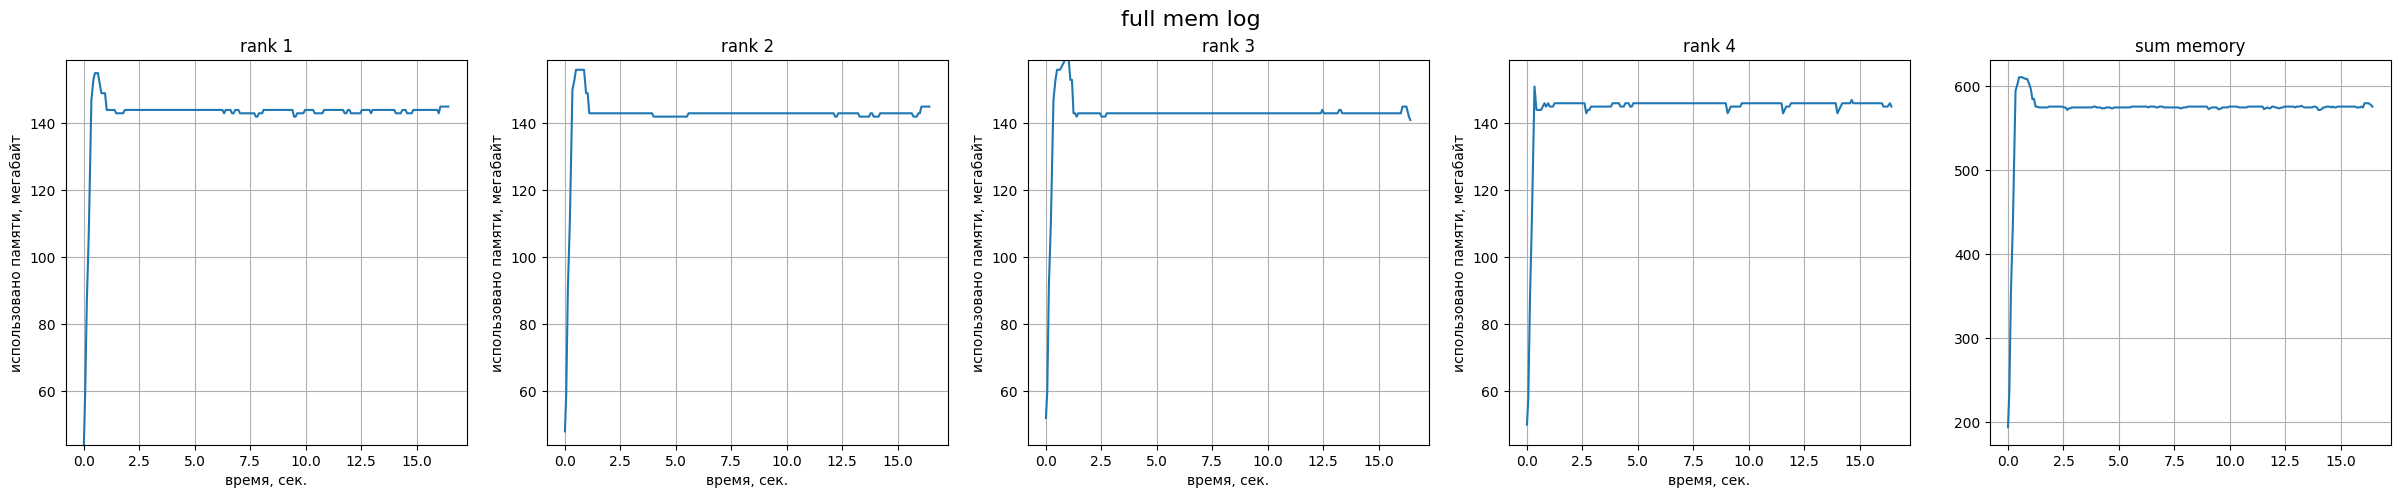

In [115]:
def memory_parser(filename):
    memdf = pd.read_csv(
        filename,
        index_col=0,
        header = 0,
    )
    memdf = memdf.rename(
        dict([(pid, f'rank {i+1}') for i, pid in enumerate(memdf.columns)]), 
        axis=1
    )

    return memdf


def plot_memdf(memdf, title = 'full mem log'):
    fig, axs = plt.subplots(nrows=1, ncols=len(memdf.columns)+1, figsize=(30, 5), dpi=100)
    fig.suptitle(title, fontsize=16)
    
    mem_min = min(memdf.min(axis=1))
    mem_max = max(memdf.max(axis=1))
    
    print('MAX MEM CONSUMPTION')
    print(memdf.max(axis=0))
    
    x = (memdf.index - memdf.index.min())/1000
    
    for i, colname in enumerate(memdf.columns):
        ax = axs[i]
#         x = memdf.index
        y = memdf[colname]
        ax.plot(x, y)
        ax.set_xlabel('время, сек.')
        ax.set_ylabel('использовано памяти, мегабайт')
        ax.set_ylim([mem_min, mem_max])
        ax.title.set_text(colname)
        ax.grid()
    plt.plot()
    
    ax = axs[-1]
#     x = memdf.index
    y = memdf.sum(axis=1)
    ax.plot(x, y)
    ax.title.set_text('sum memory')
    ax.grid()

    
memlog = memory_parser("mem.csv")
plot_memdf(memlog)

In [121]:
def process_log(filename):
    logdf = pd.read_csv(
        filename,
        names=['timestamp', 'rank', 'iter', 'step', 'action'],
        sep=' ',
#         skiprows=lambda i: False
    )
    print(f"sum time: {(logdf['timestamp'].max() - logdf['timestamp'].min())/1000} sec")
    print(f"start timestamp: {logdf['timestamp'].min()}")
    print(f"finish timestamp: {logdf['timestamp'].max()}")
    print(logdf['action'].unique())
    
    # разбили по (итерация, шаг, ранк)
    step_groups = logdf.groupby(['iter', 'step', 'rank'])
    keys =sorted(
        step_groups.groups.keys(), 
    )
    blocks = [step_groups.get_group(key).drop(['iter', 'step', 'rank'], axis=1) for key in keys]
    
#     blocks = list(map(make_cumsum, blocks))
    blocks = [
        {'iter': key[0], 'step': key[1], 'phase': (key[0], key[1]), 'rank': key[2], 'log': block} for key, block in zip(keys, blocks)
    ]
    return blocks


def make_cumsum(block):
    stepdf = block['log']
    
    stepdf = stepdf.reset_index().drop(['index'], axis=1)
    # переходим в one-hot
    stepdf = pd.concat(
        [stepdf, pd.get_dummies(stepdf['action'], dtype=int)], axis=1
    )
    action_types = stepdf['action'].unique()
    stepdf = stepdf.drop(['action'], axis=1)
    
    for at in action_types:
        stepdf[at] = stepdf[at].cumsum()  
    
    block['log'] = stepdf
    return block


    
process_time_unit = 10
def make_processing_speed(cs_block):
    stepdf = cs_block['log']
    
    stepdf = stepdf.groupby('timestamp').tail(1)
    stepdf = stepdf[stepdf['timestamp'] % process_time_unit == 0]
    
    for colname in stepdf.columns[1:]:
        stepdf[colname] = stepdf[colname] - stepdf[colname].shift(1)
    
    stepdf = stepdf.fillna(0)
    cs_block['log'] = stepdf
    return cs_block

In [122]:
def plot_unique_step(blocks):    
    fig, axs = plt.subplots(nrows=1, ncols=len(blocks), figsize=(30, 5), dpi=100)
    fig.suptitle(f'iter: {blocks[0]["iter"]}, step: {blocks[0]["step"]}', fontsize=16)
    
    cols_to_plot = list(filter(lambda x: x.startswith('send') or x.startswith('recv'), blocks[0]['log'].columns))
    cols_to_plot = sorted(cols_to_plot, key = lambda x: x[::-1])
    
    
    # ищем минимальные границы
    tmin = min([block['log']['timestamp'].min() for block in blocks])
    tmax = max([block['log']['timestamp'].max() for block in blocks])
    ymin = 0
    ymax = max([
        max([block['log'][colname].max() for colname in cols_to_plot])
        for block in blocks
    ])

    
    # перебираем узлы
    for i, block in enumerate(blocks):
        ax = axs[i]
        # перебираем все виды действий
        for colname in cols_to_plot:
            x = np.linspace(0, tmax-tmin, len(block['log']), True)
            y = block['log'][colname]
            ax.plot(x, y, label=colname)
#             ax.set_xlim([tmin, tmax])
#             ax.set_ylim([ymin, ymax])
            ax.grid(True)
            ax.legend()
            ax.title.set_text(f'rank {block["rank"]}')
        
            
    plt.show()

In [123]:
def report_log(file):
    # парсим лог, разделяем его на блоки (итерация, шаг, ранк)
    blocks = process_log(file)

    # выделим (итерация, шаг)
    phases = set(map(lambda x: x['phase'], blocks))
    phases = sorted(phases)

    # сгруппируем блоки в группы по (итерация, шаг)
    per_phase_groups = [
        sorted(
            list(filter(
                lambda x: x['phase'] == phase, 
                blocks
            )), 
            key = lambda x: x['rank']
        )
        for phase in phases
    ]


    # выделим timestamp'ы начала этапов
    start_tss = list(map(lambda x: x[0]['log']['timestamp'].min(), per_phase_groups))
    finish_tss = list(map(lambda x: x[0]['log']['timestamp'].max(), per_phase_groups))

    # рисуем графики    
    for phase_blocks in per_phase_groups:
        cs_blocks = list(map(make_cumsum, phase_blocks))
        # отрисуем количество обработанных запросов
        plot_unique_step(cs_blocks)
        ps_blocks = list(map(make_processing_speed, cs_blocks))
        # отрисуем скорость обработки запросов
        plot_unique_step(ps_blocks)

sum time: 15.239 sec
start timestamp: 1693125943644
finish timestamp: 1693125958883
['send_ur_inner_my_foreign' 'resv_ur_inner_my_foreign'
 'send_tag_already_knew' 'resv_tag_already_knew'
 'send_tag_parent_proposal' 'resv_tag_parent_proposal']


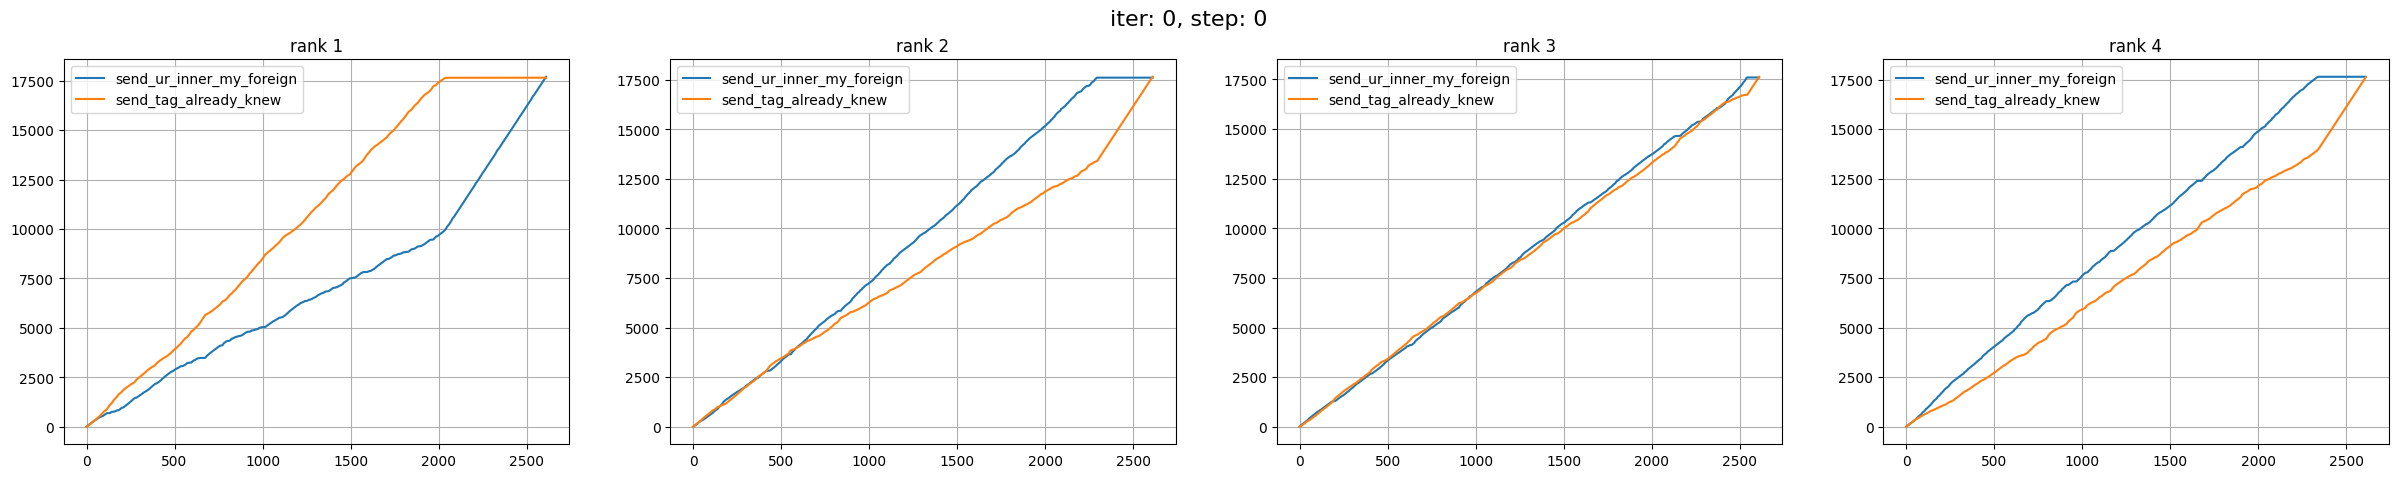

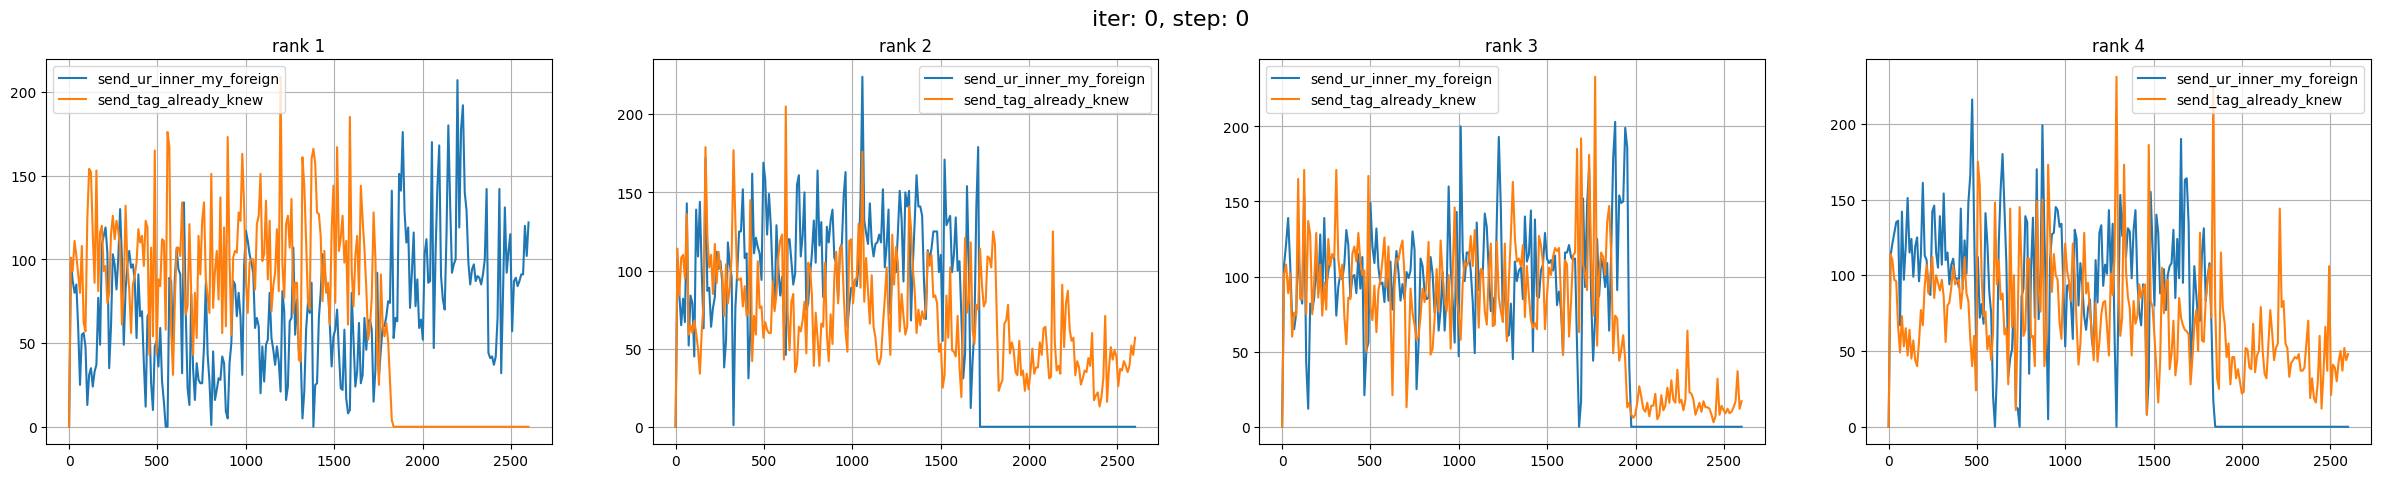

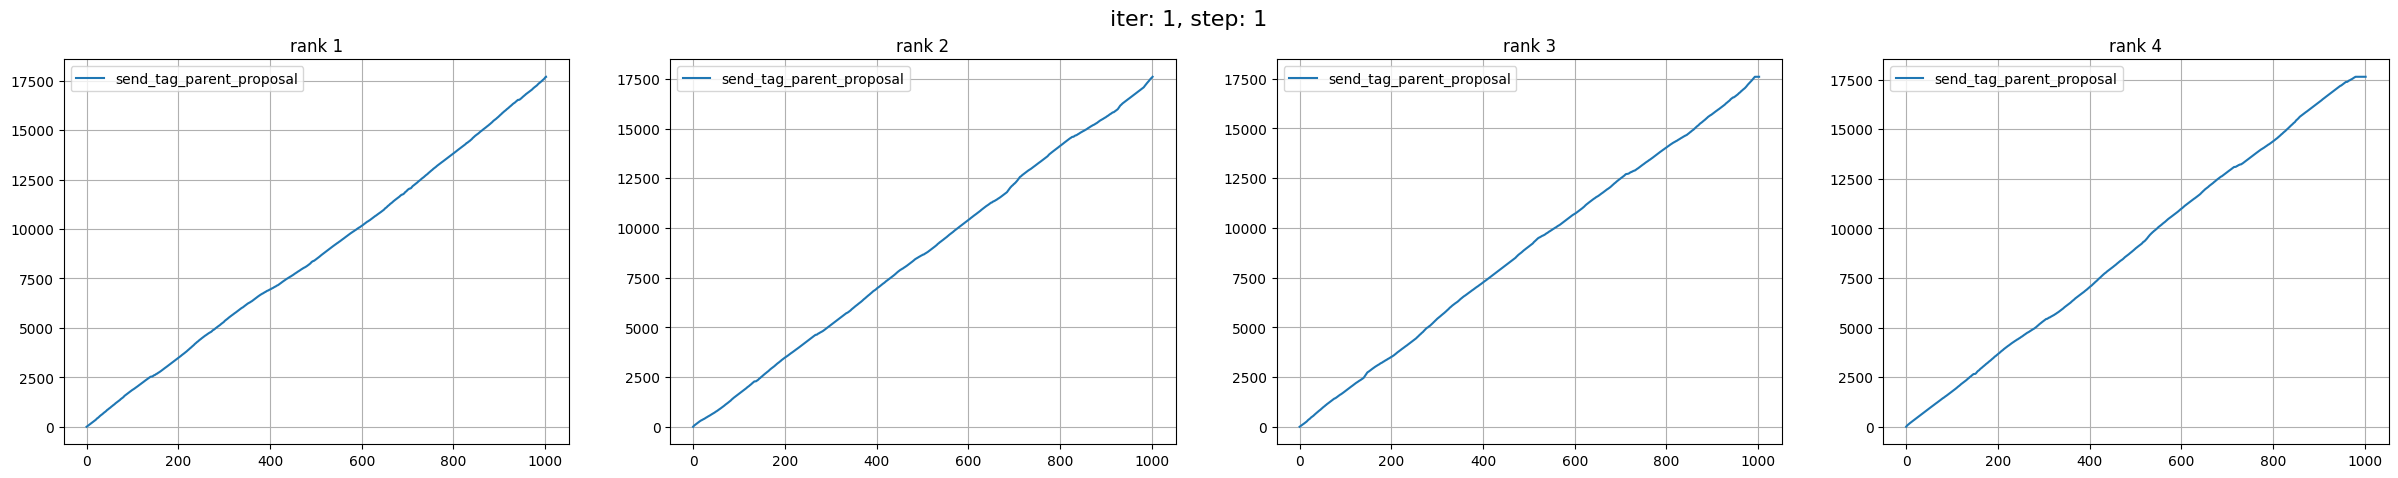

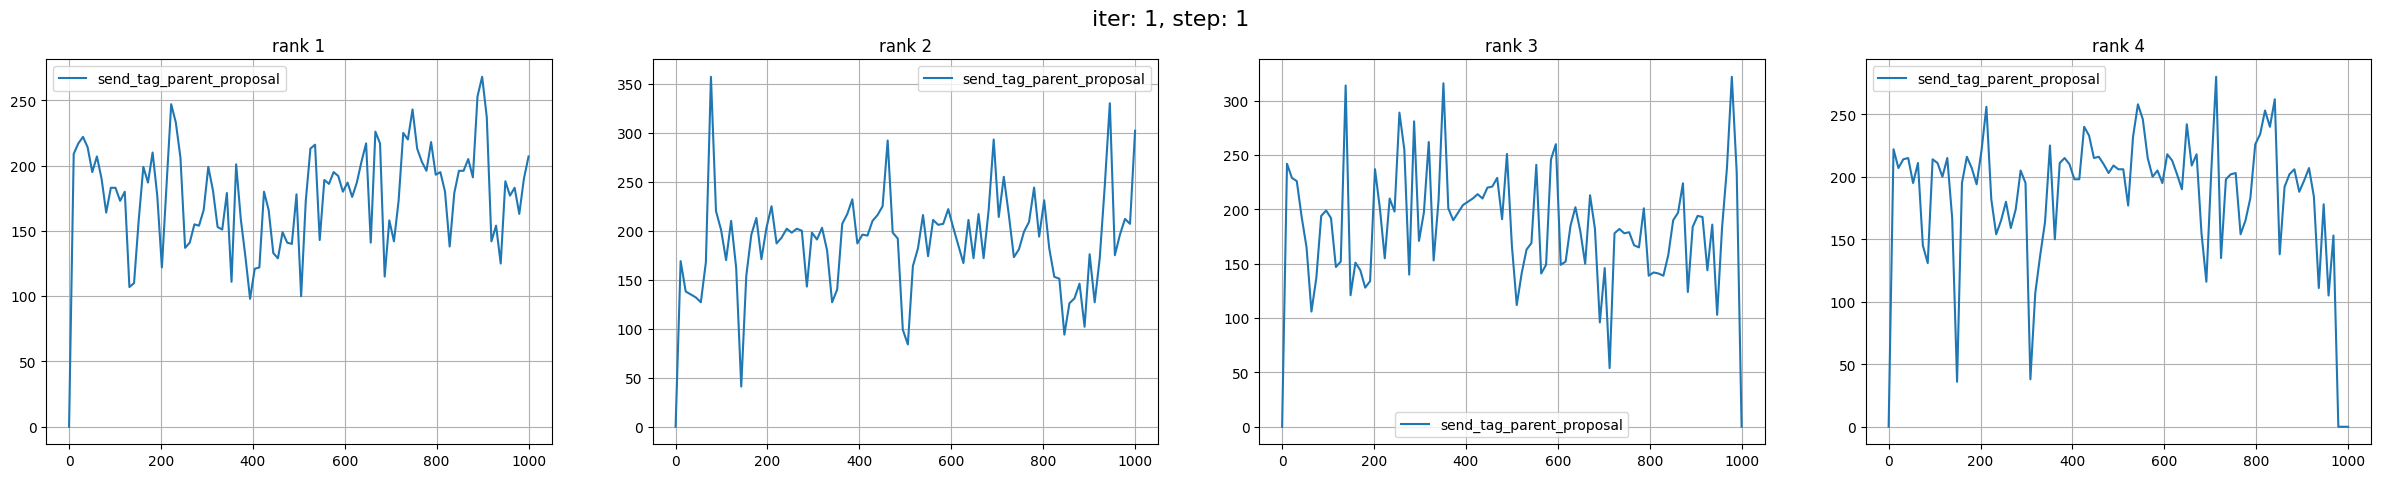

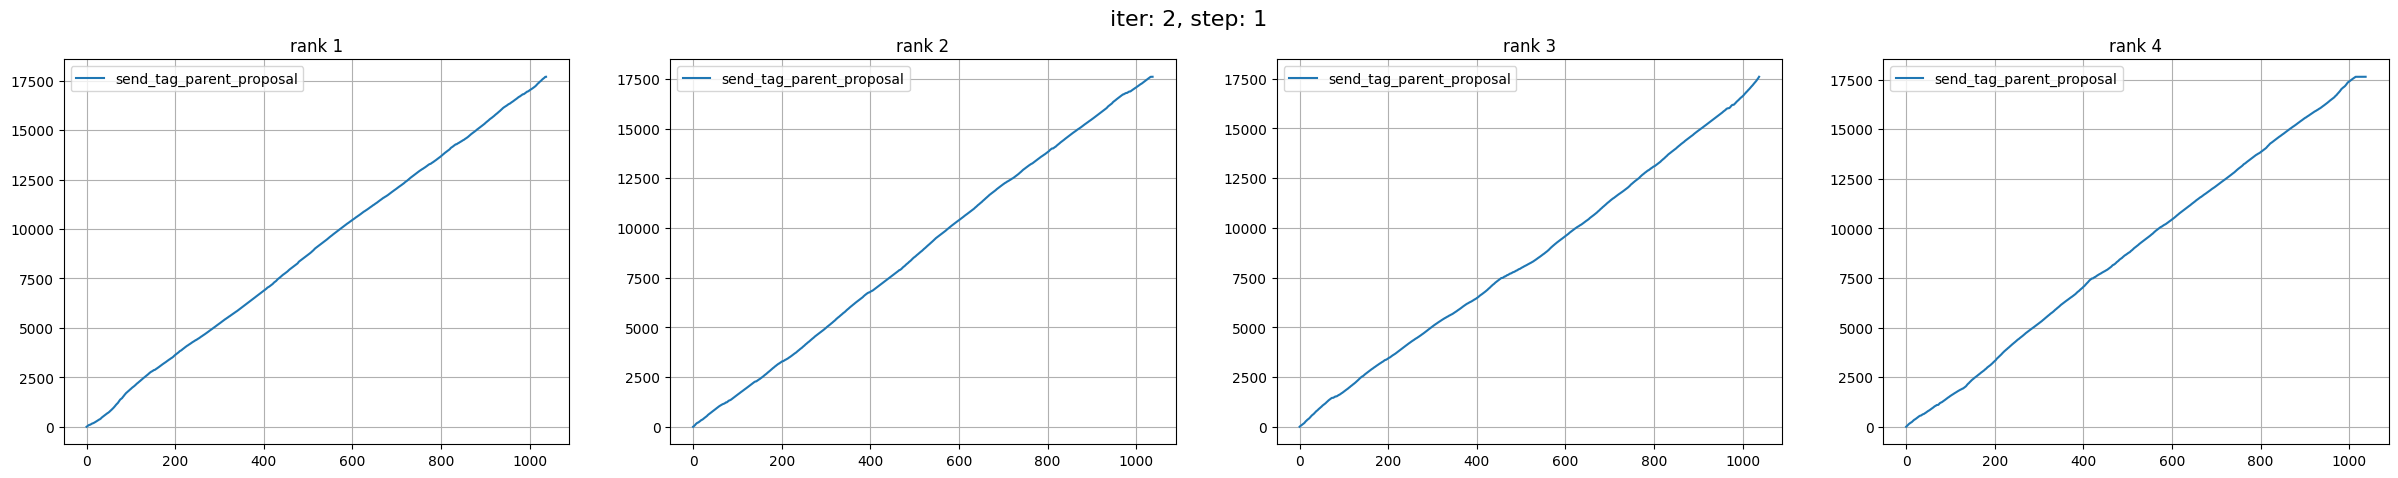

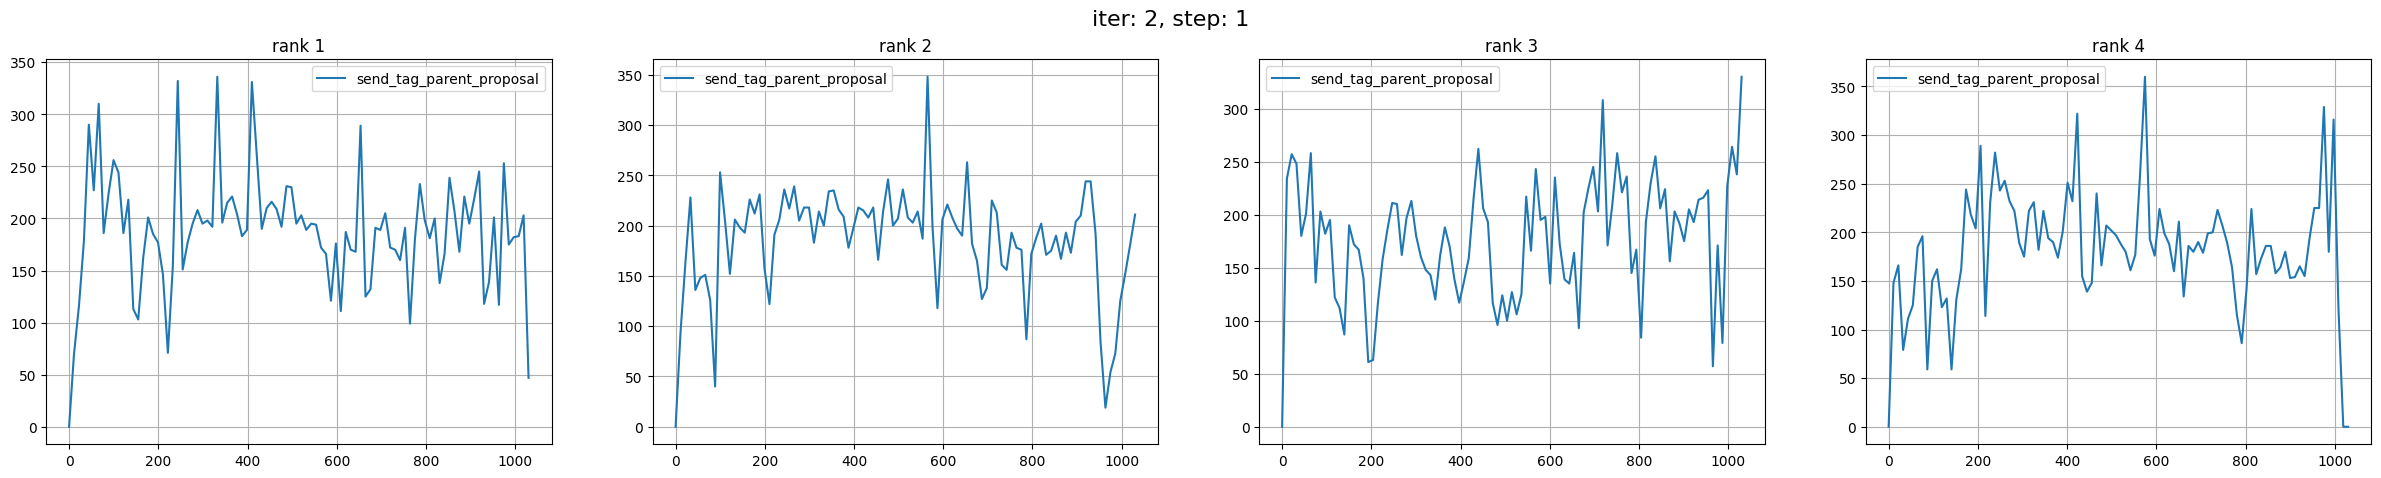

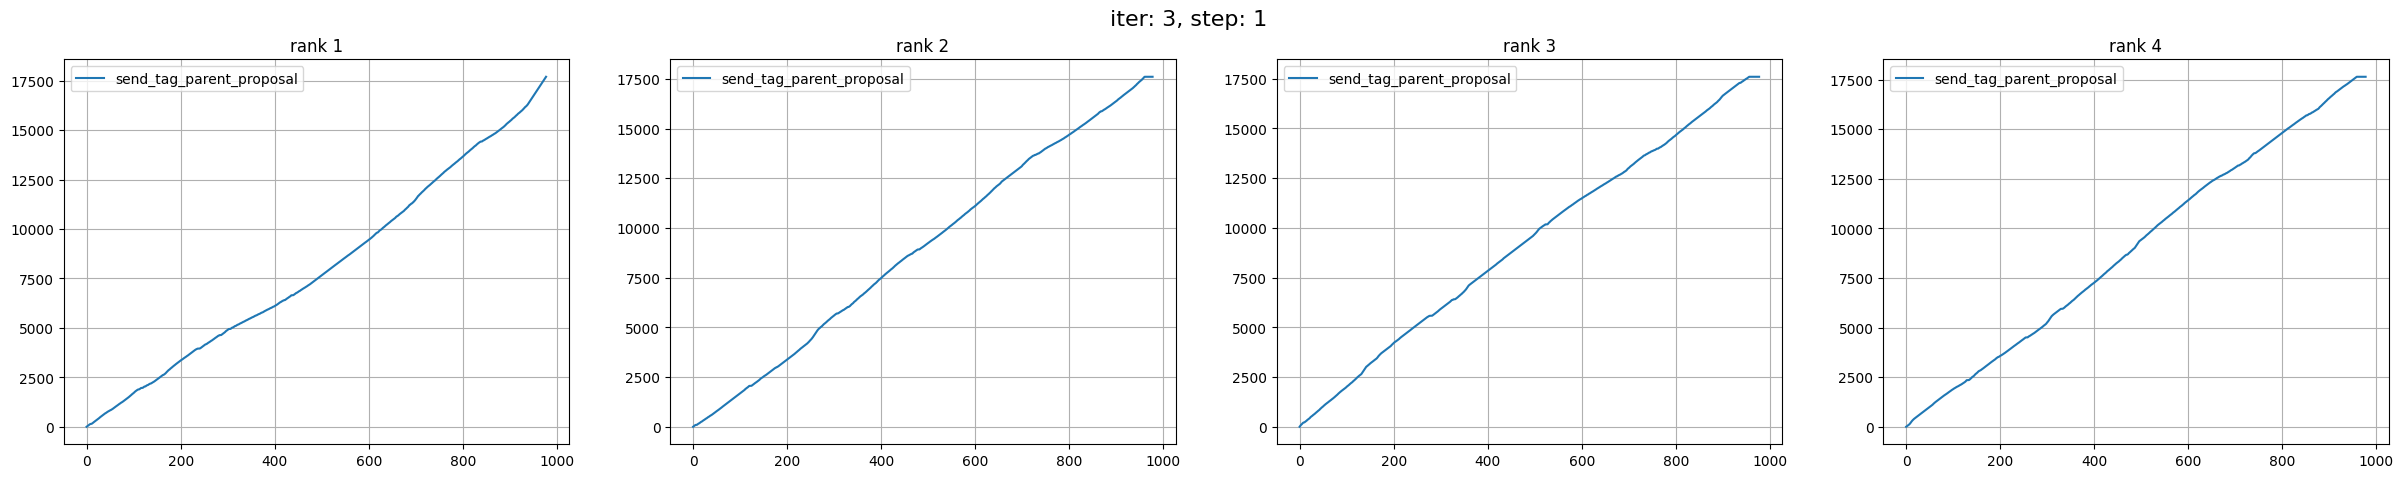

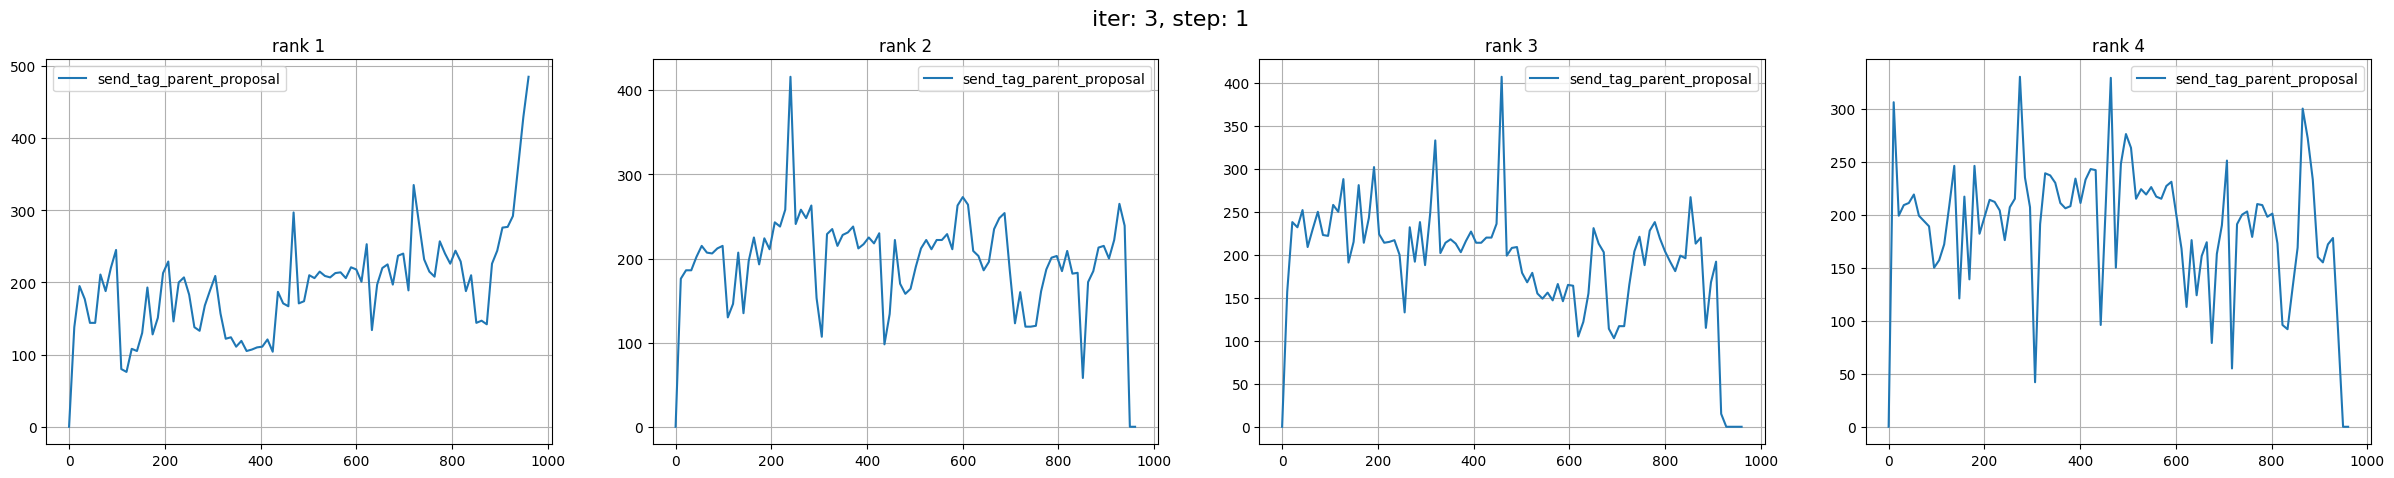

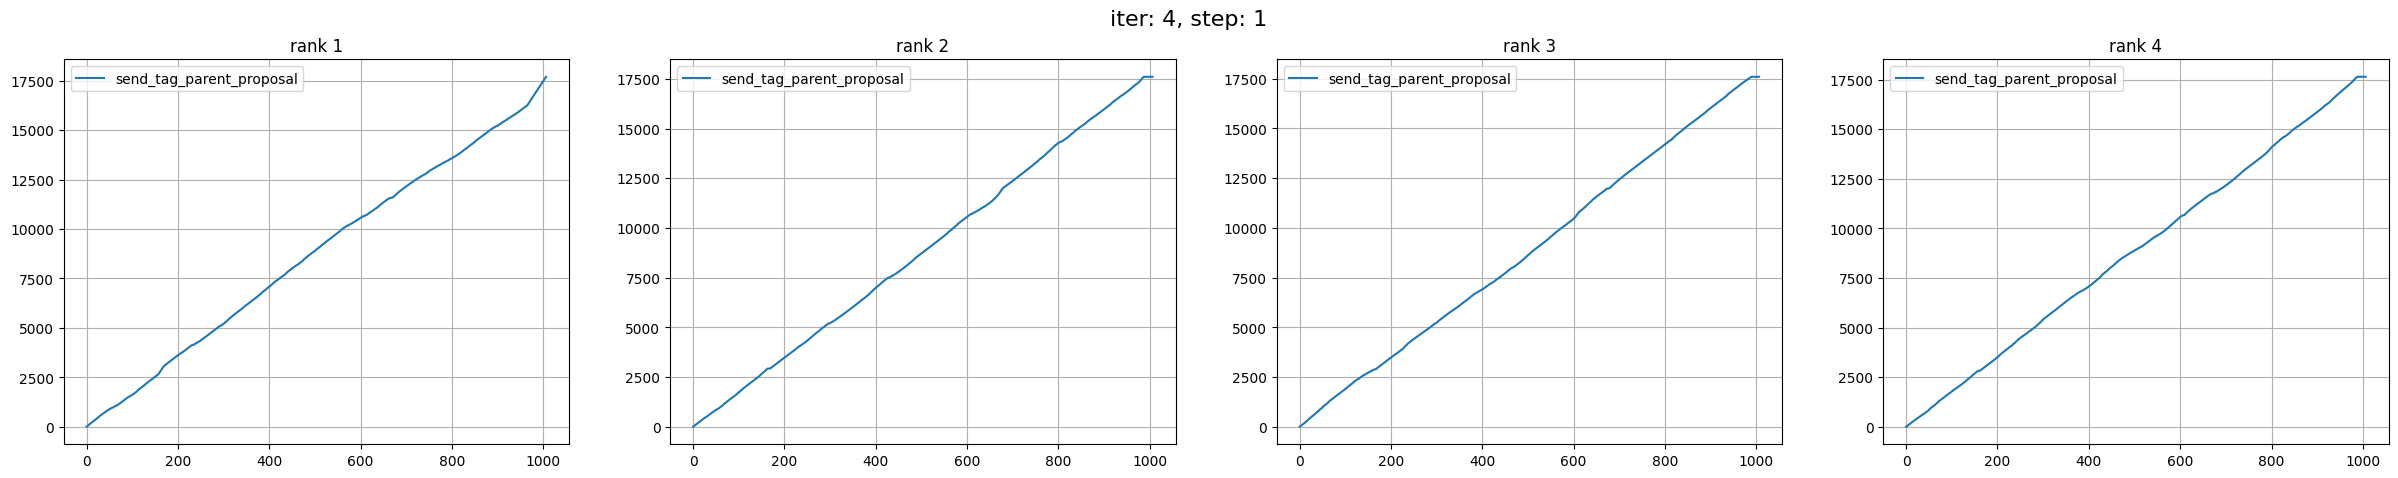

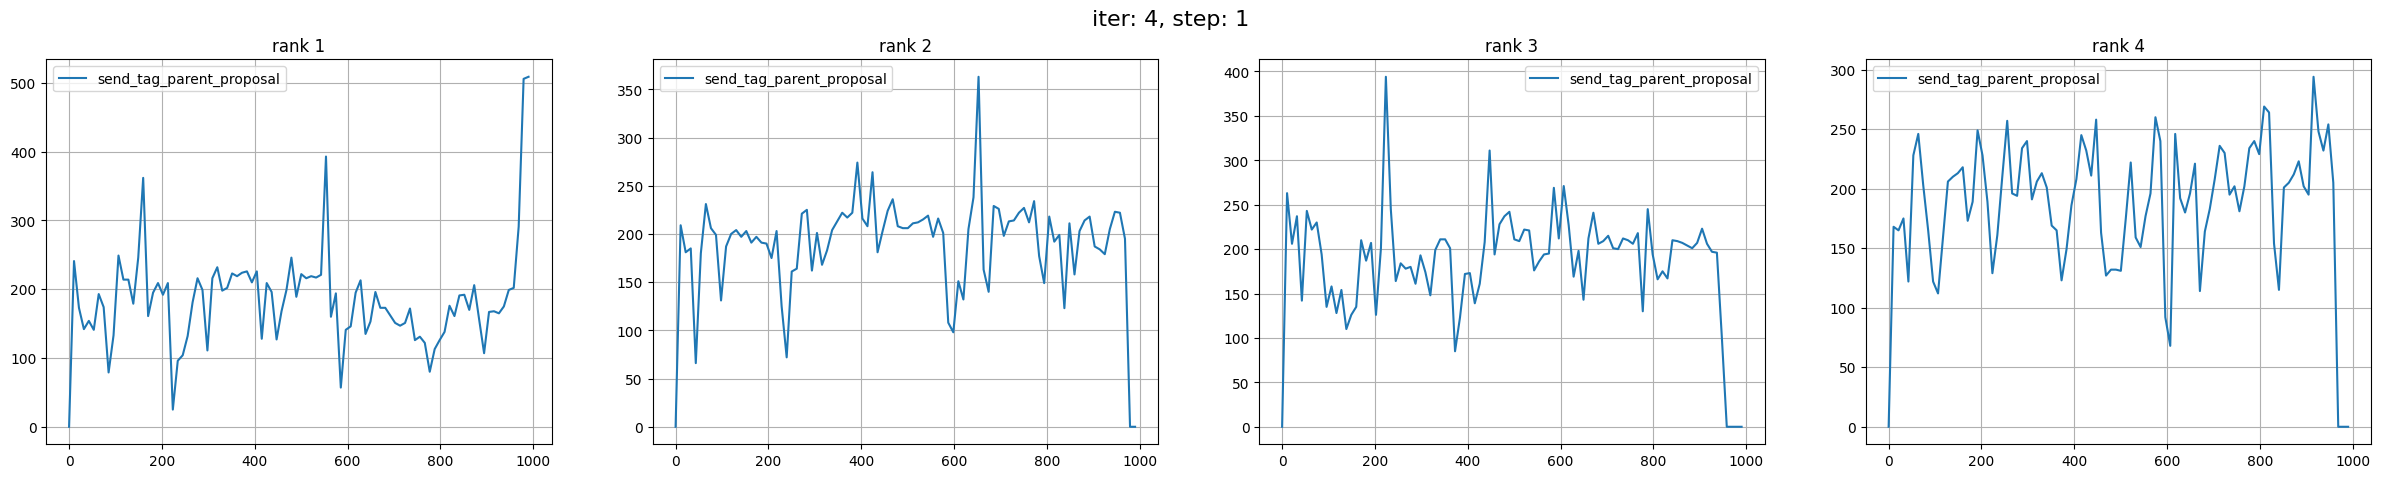

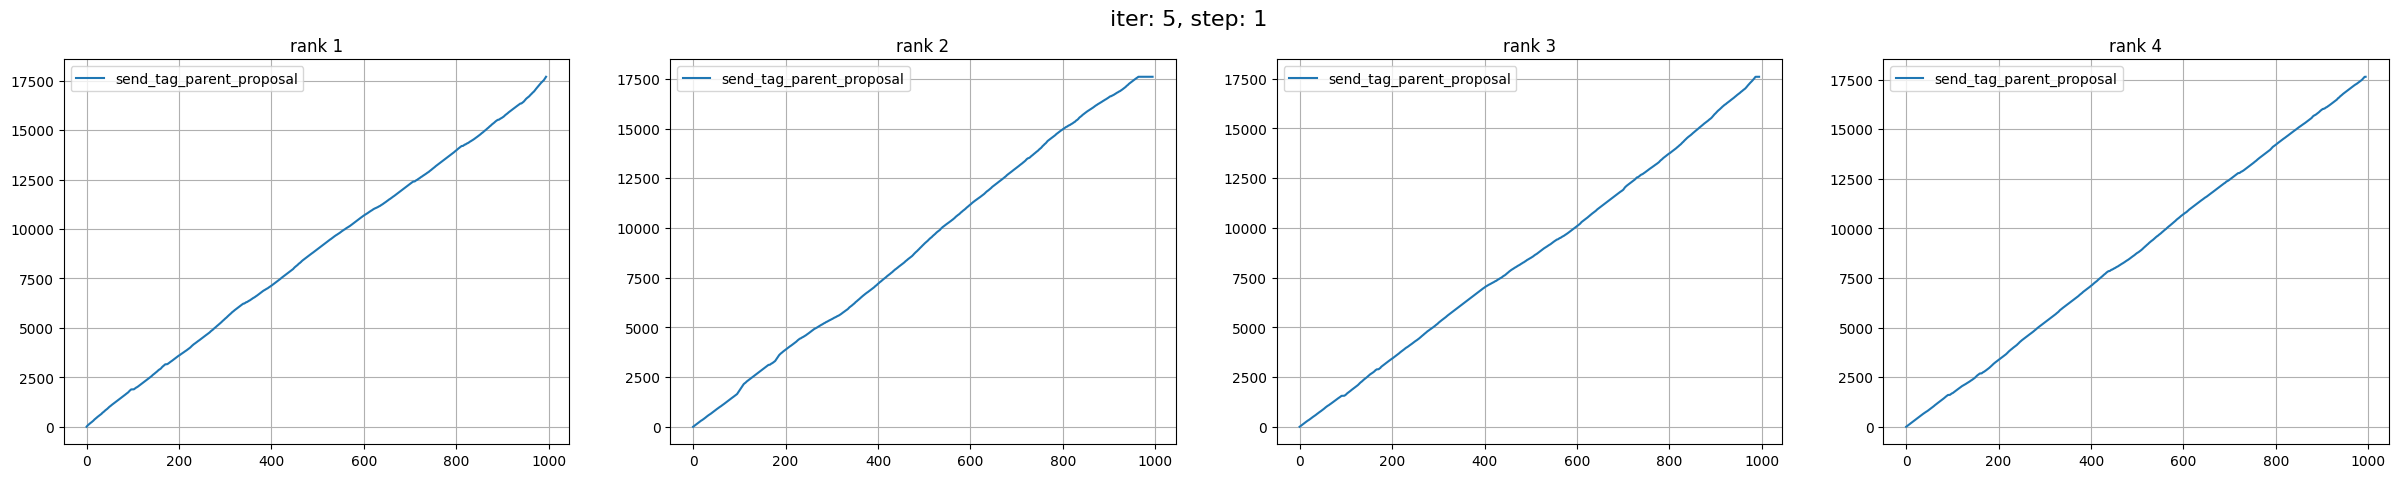

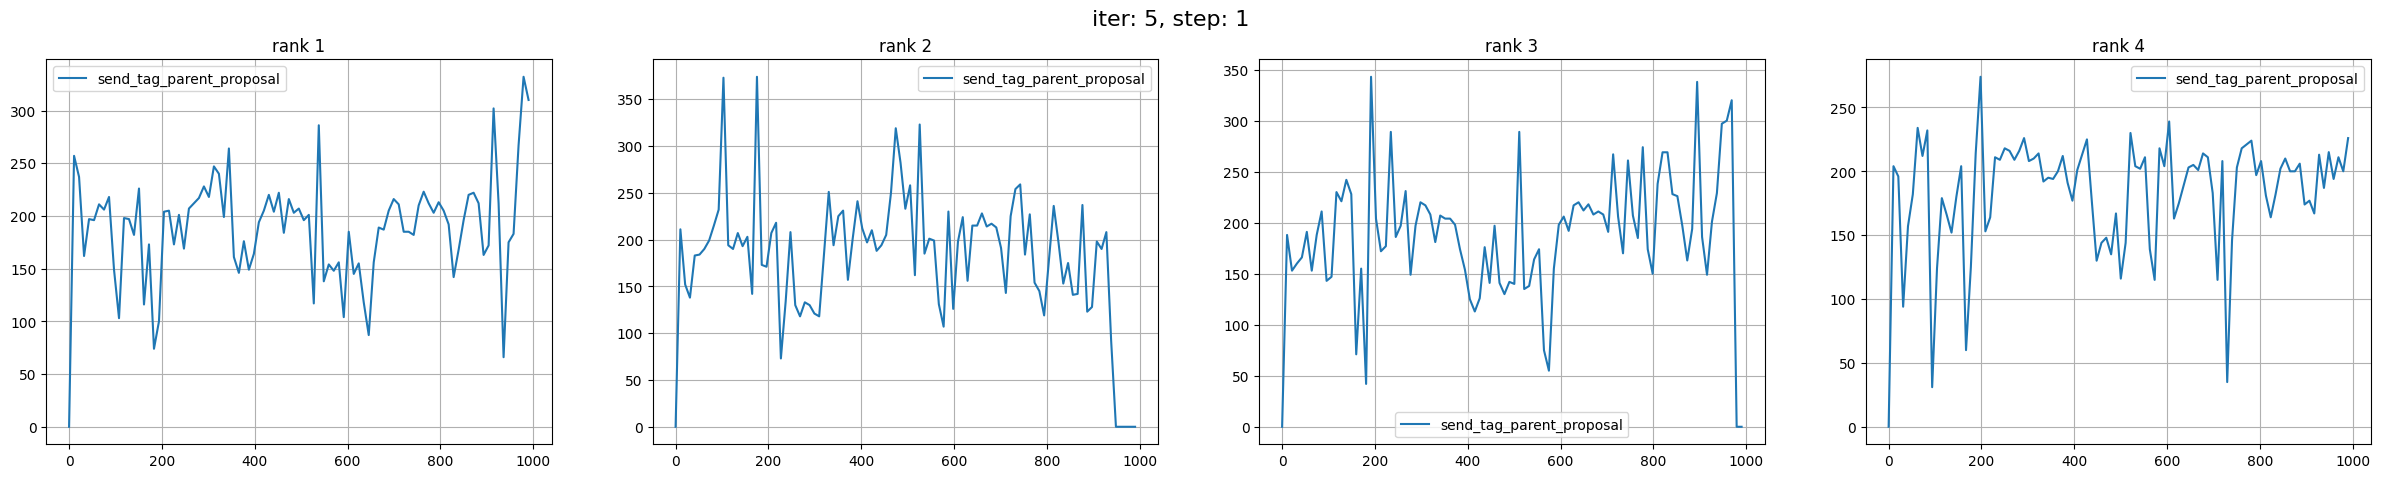

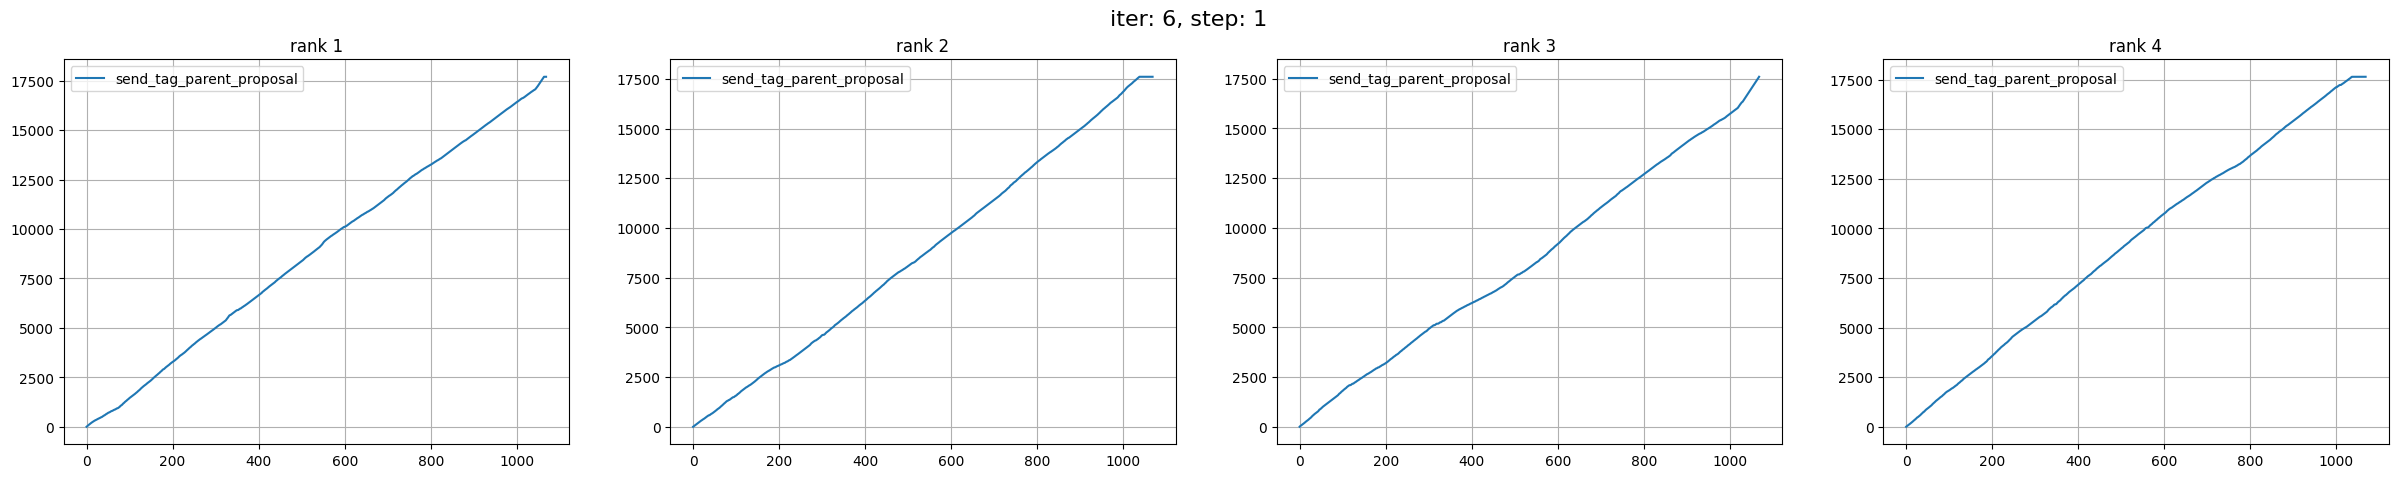

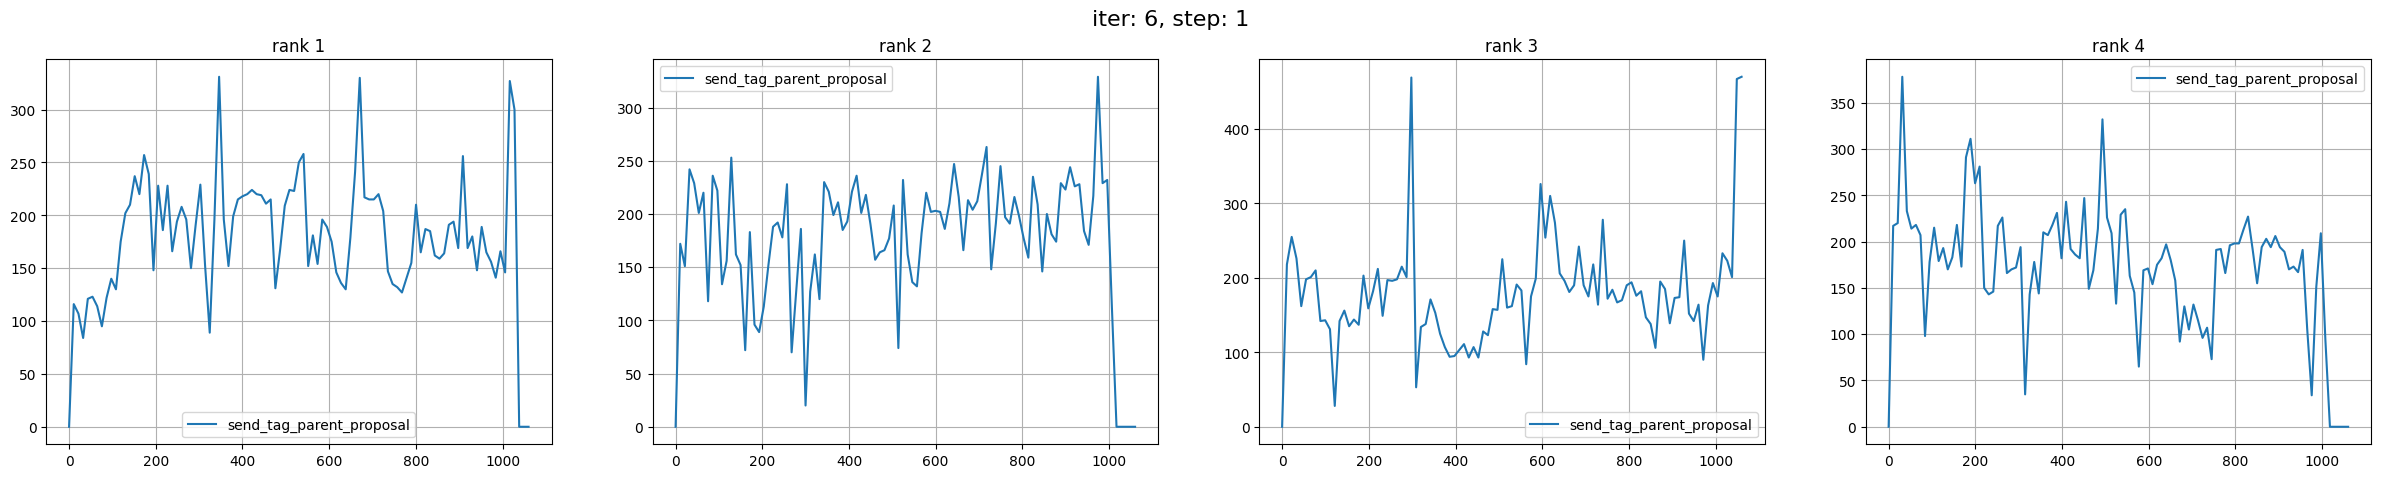

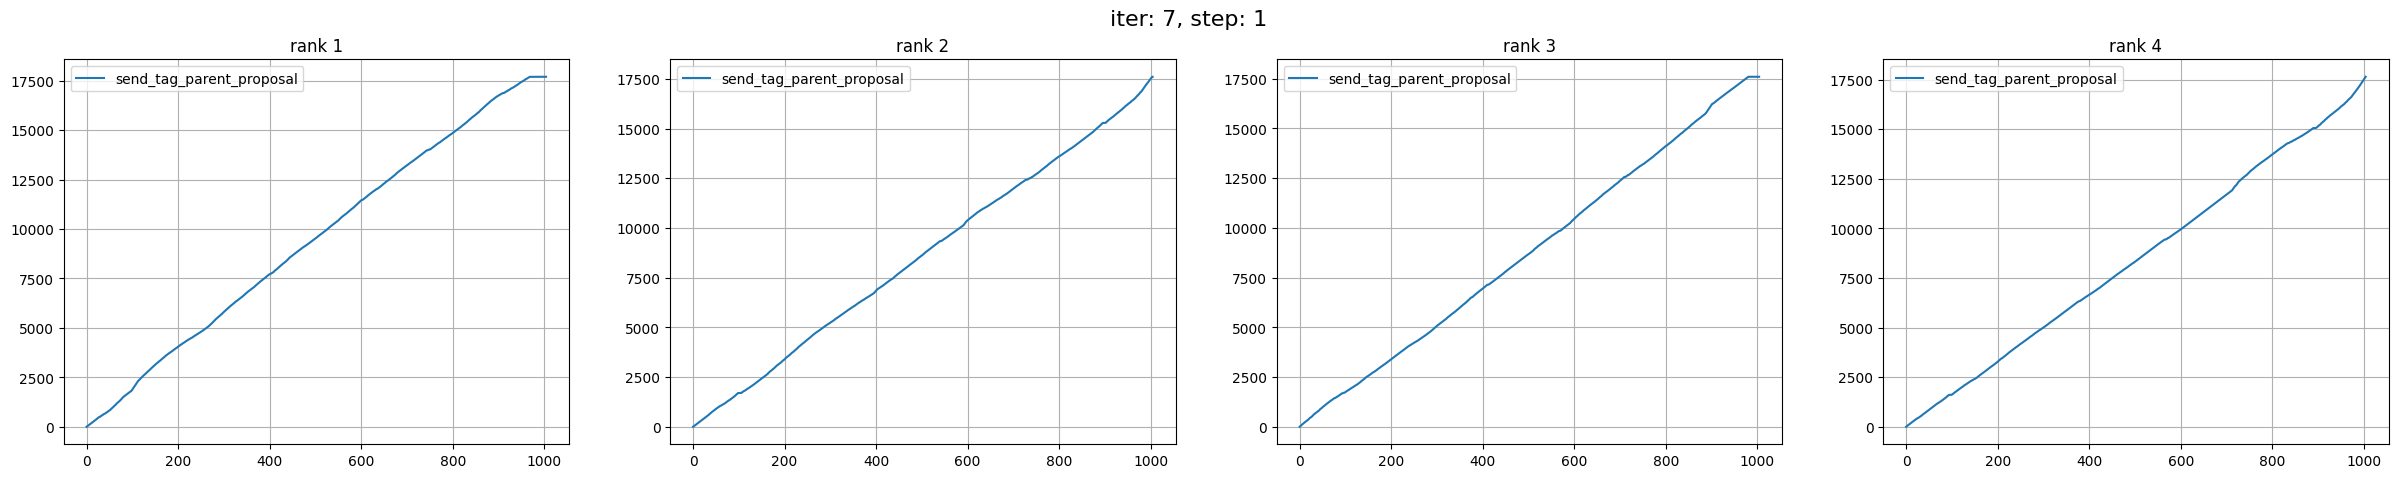

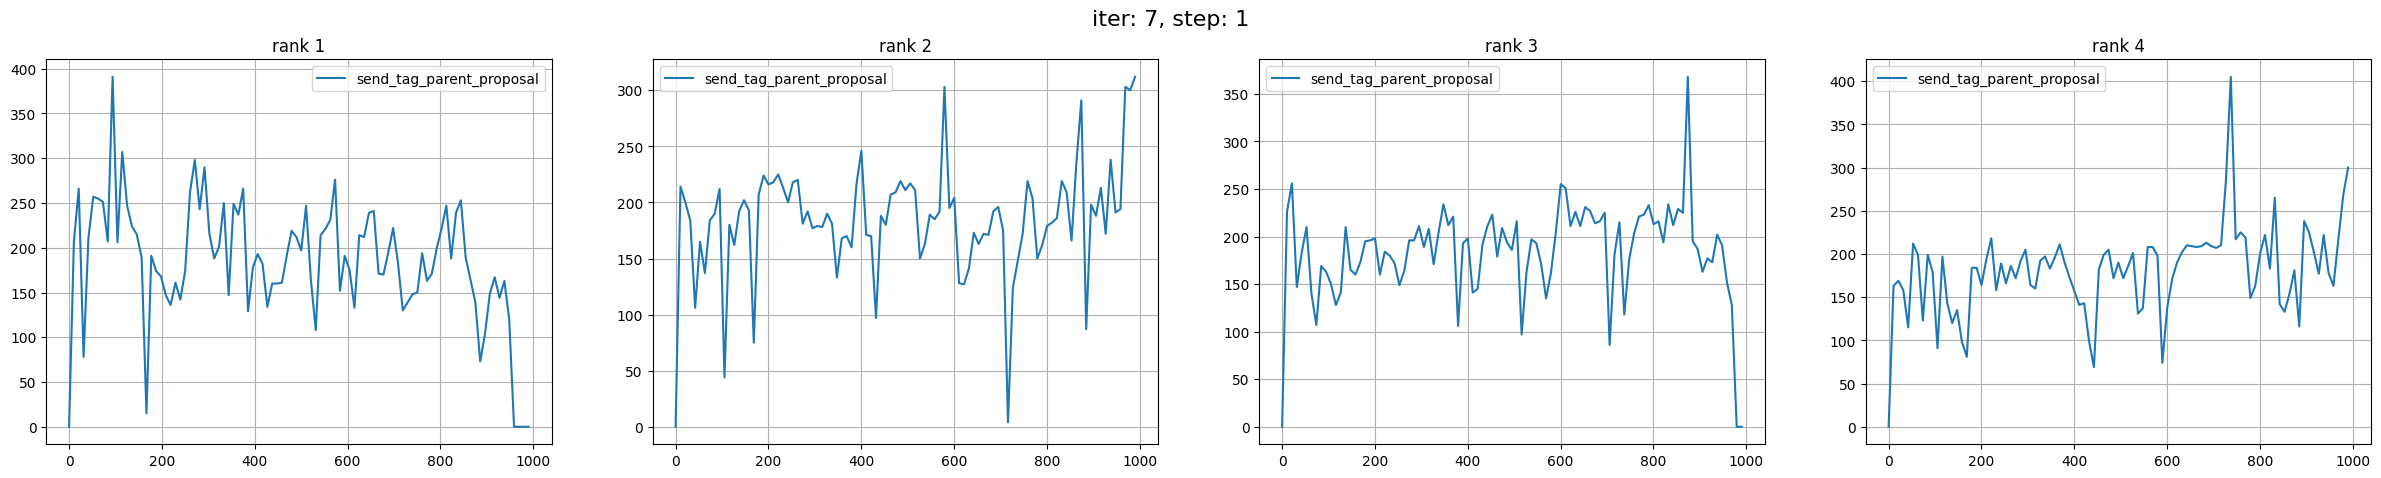

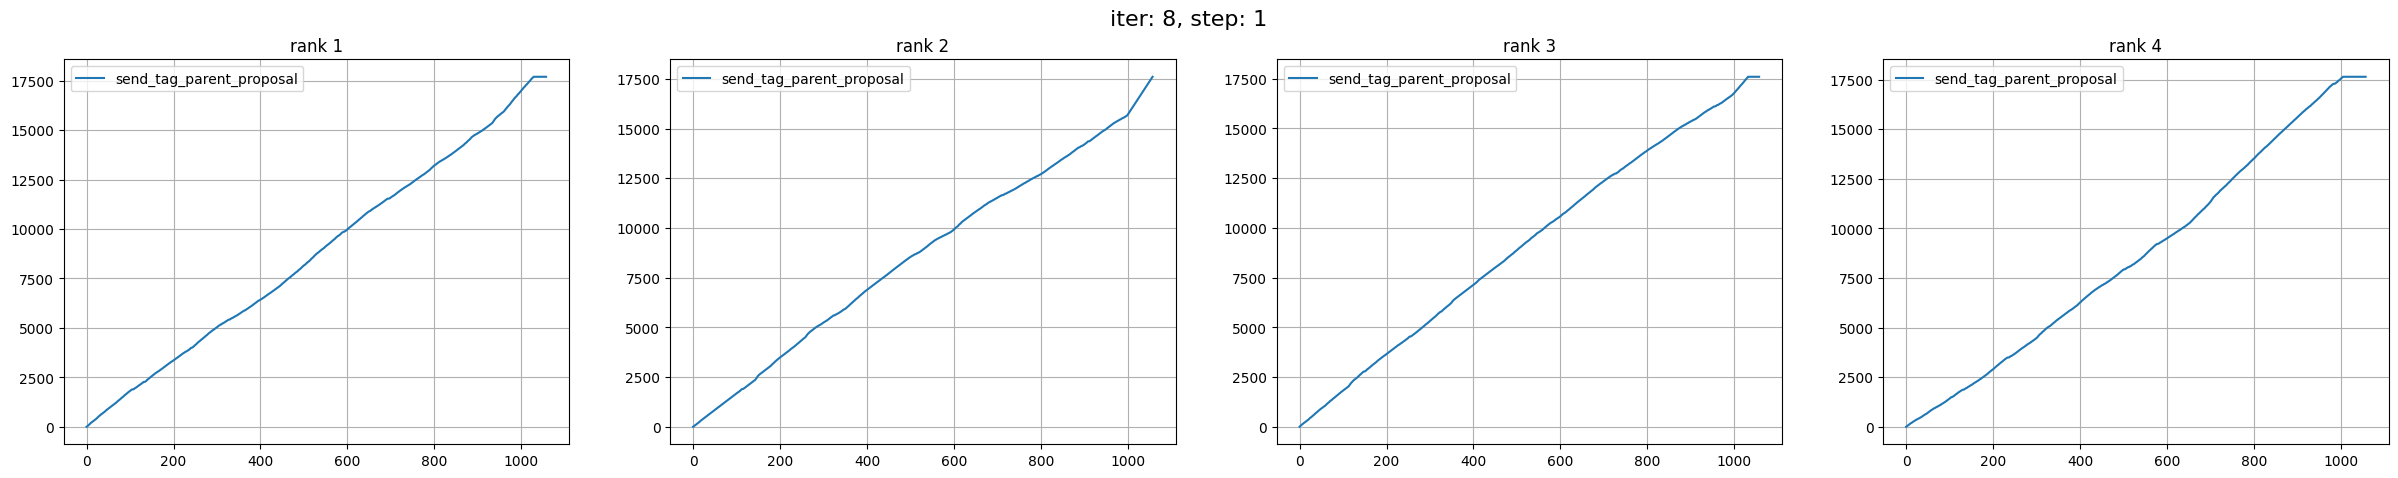

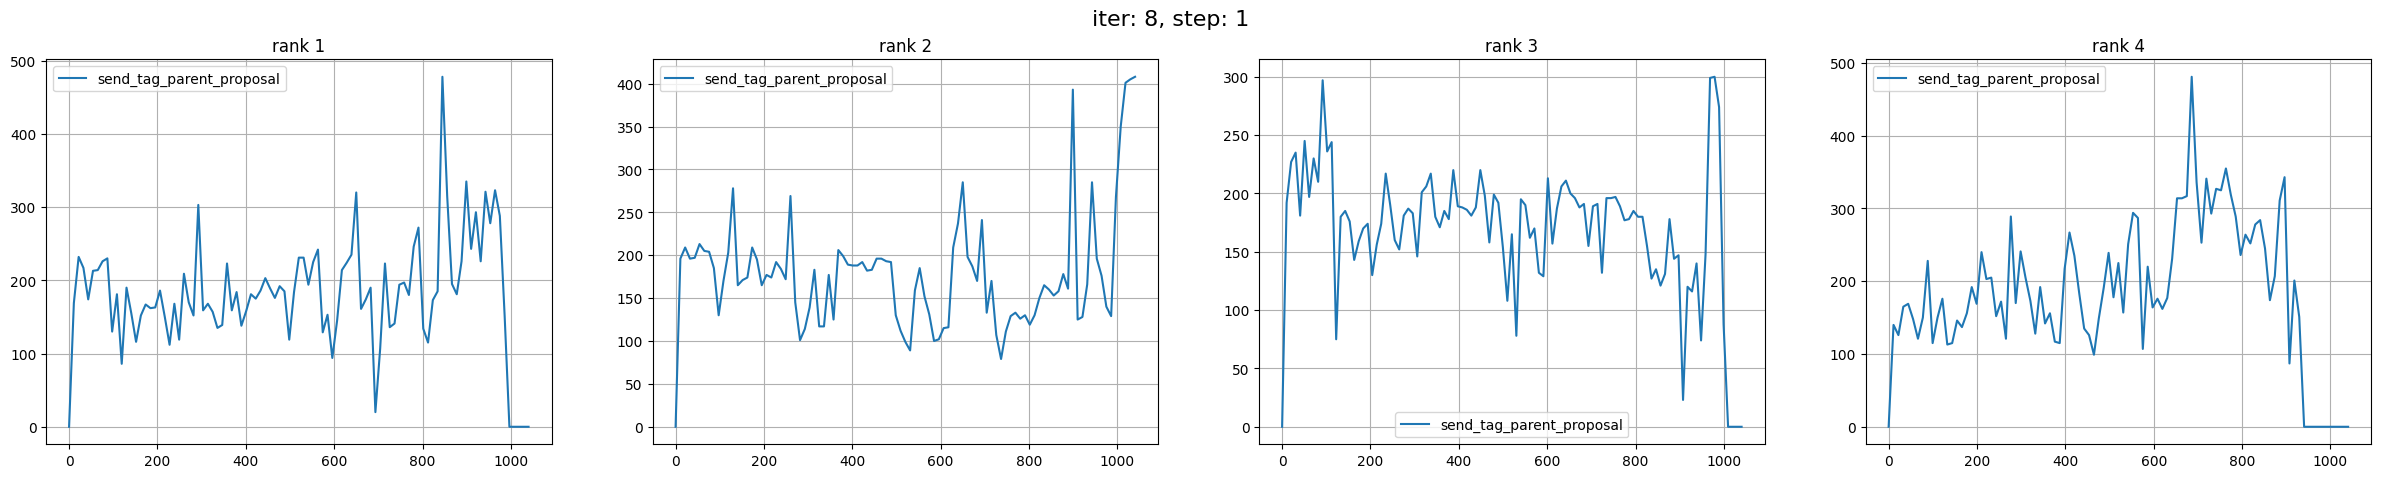

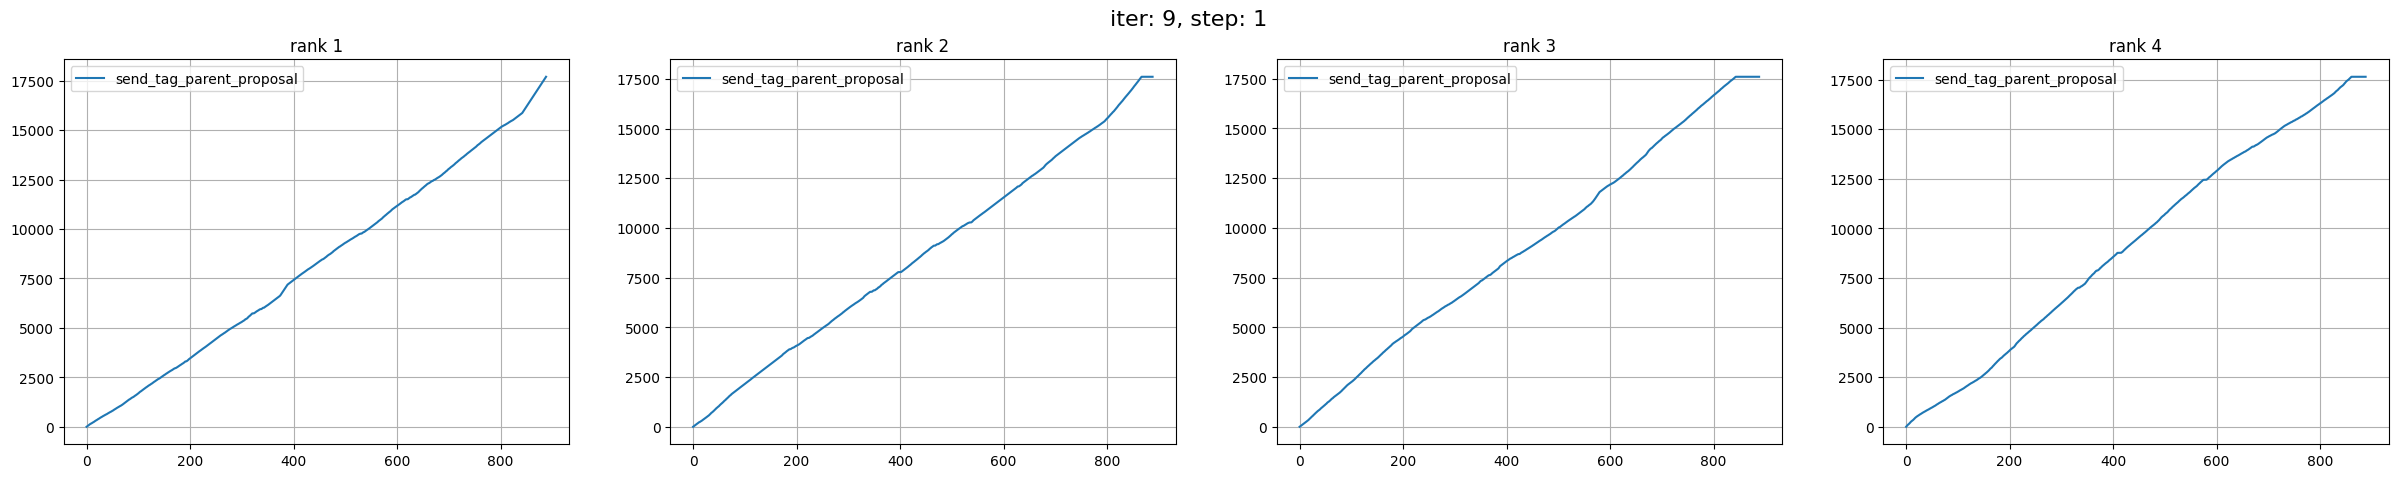

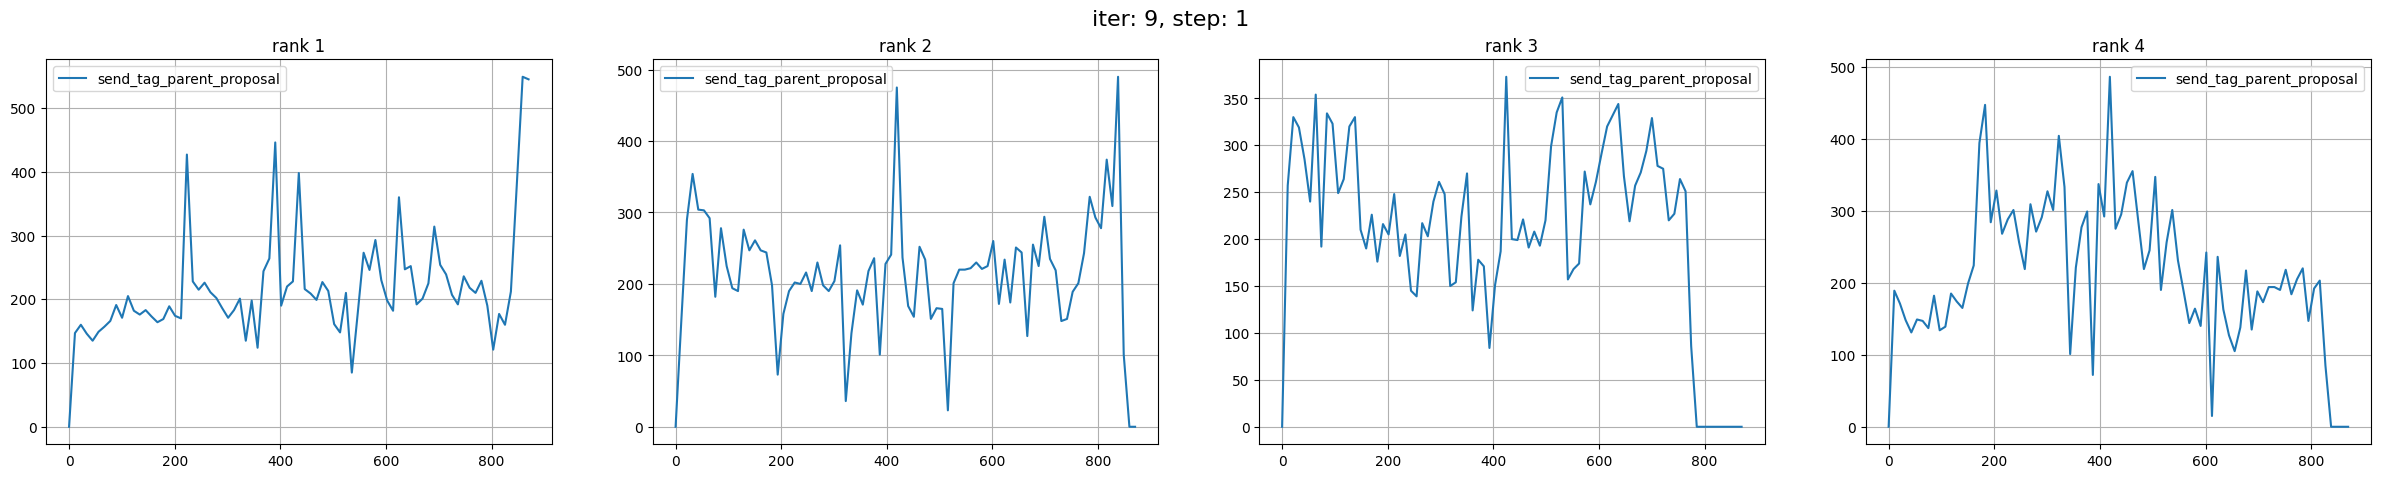

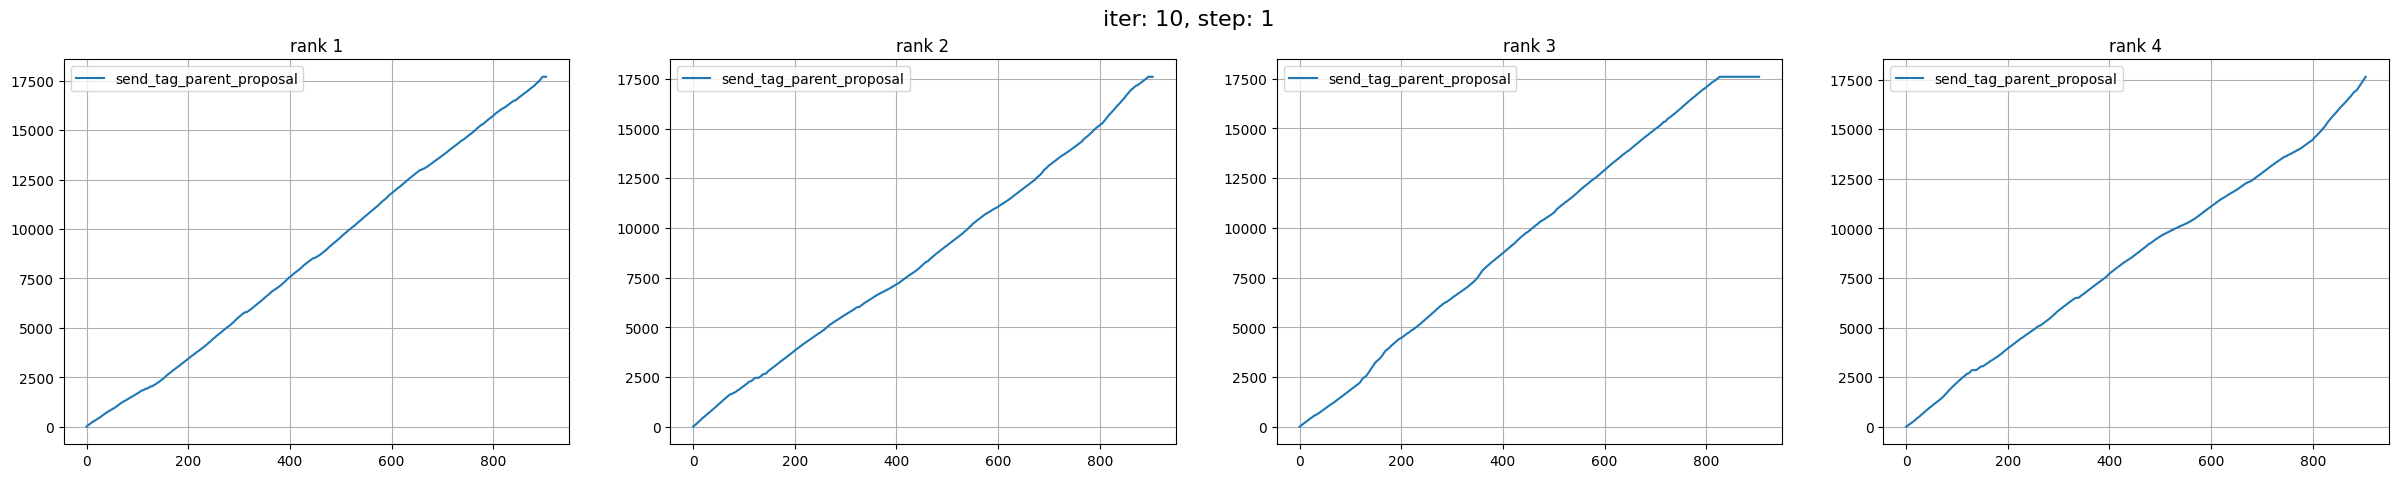

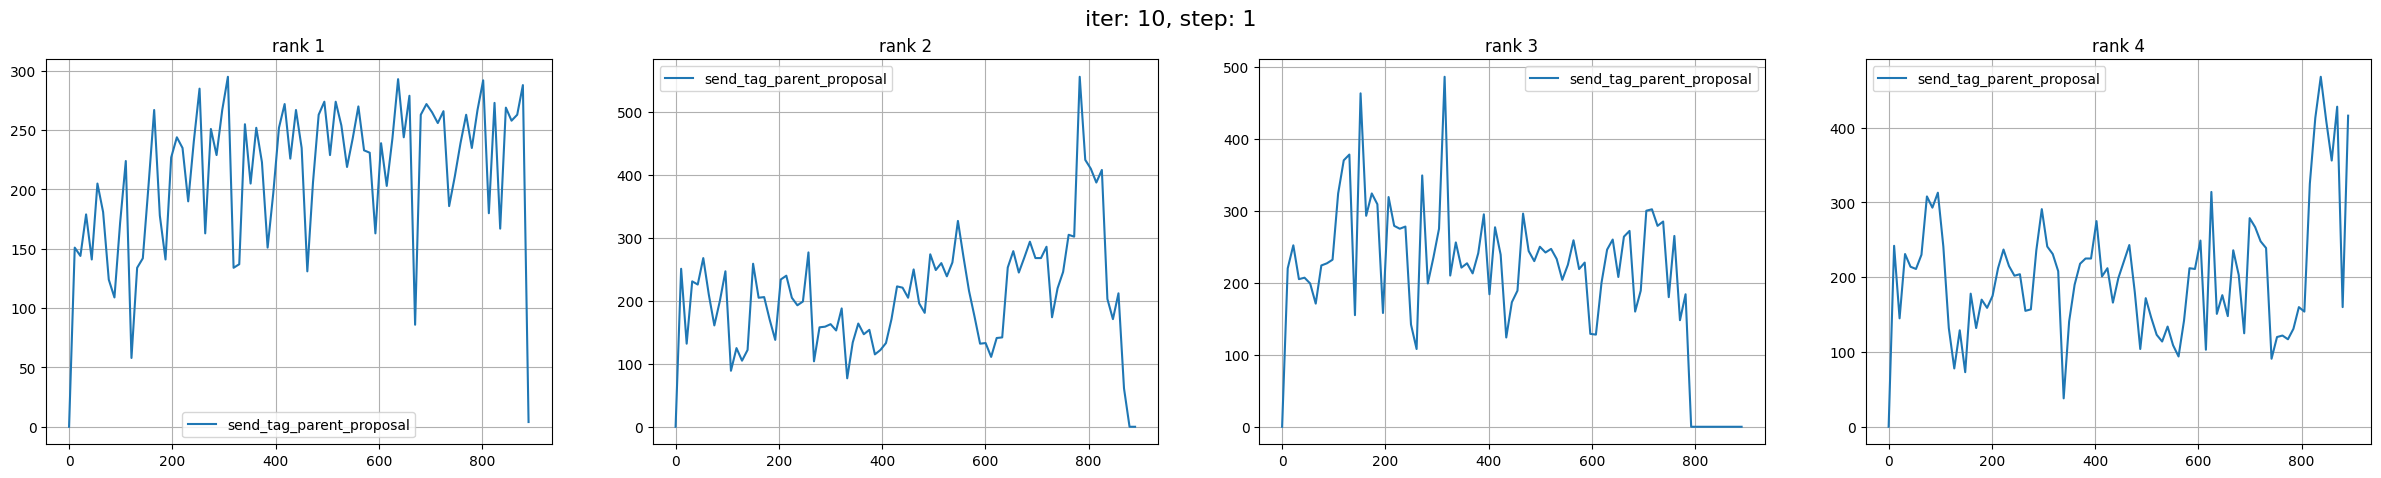

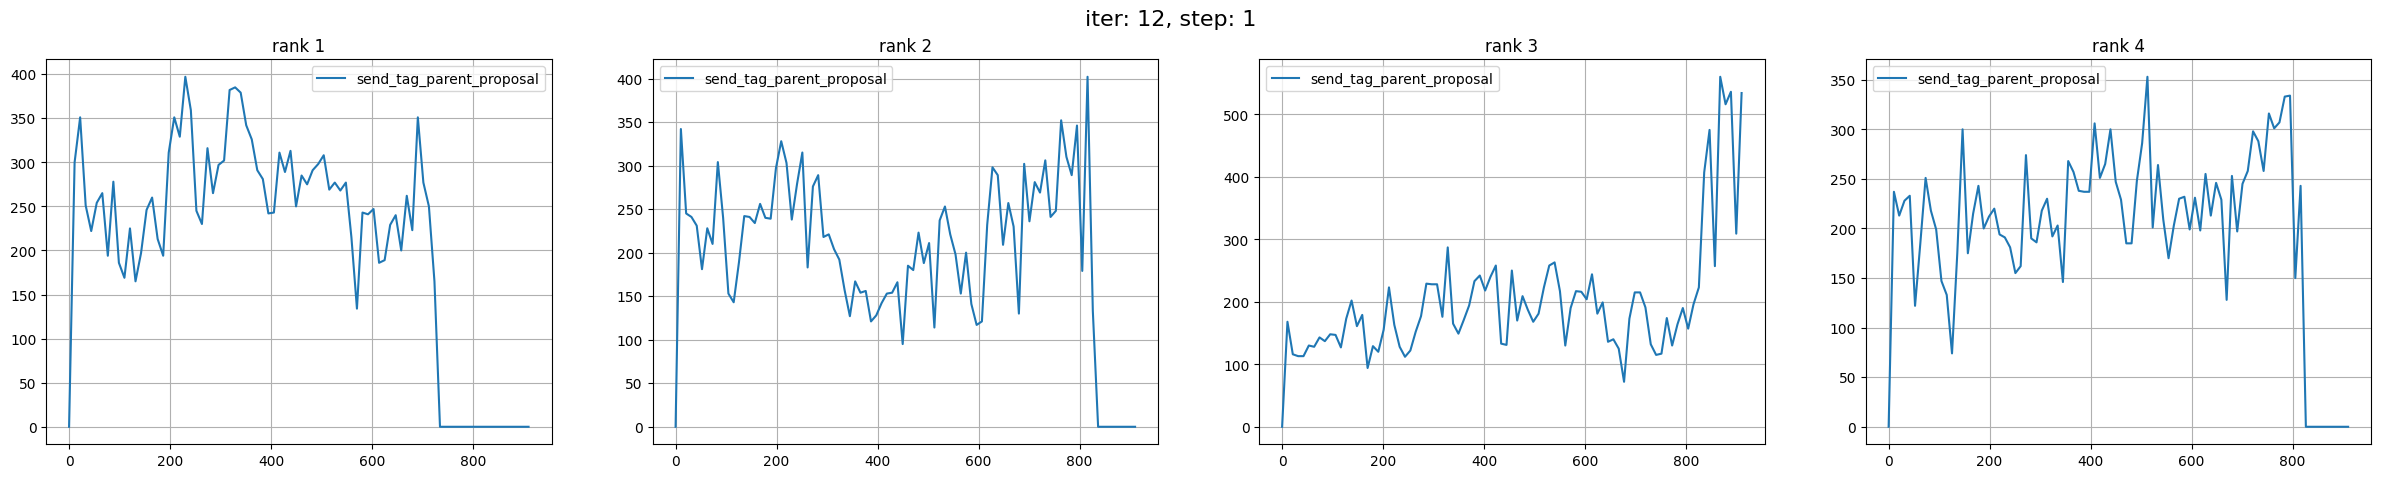

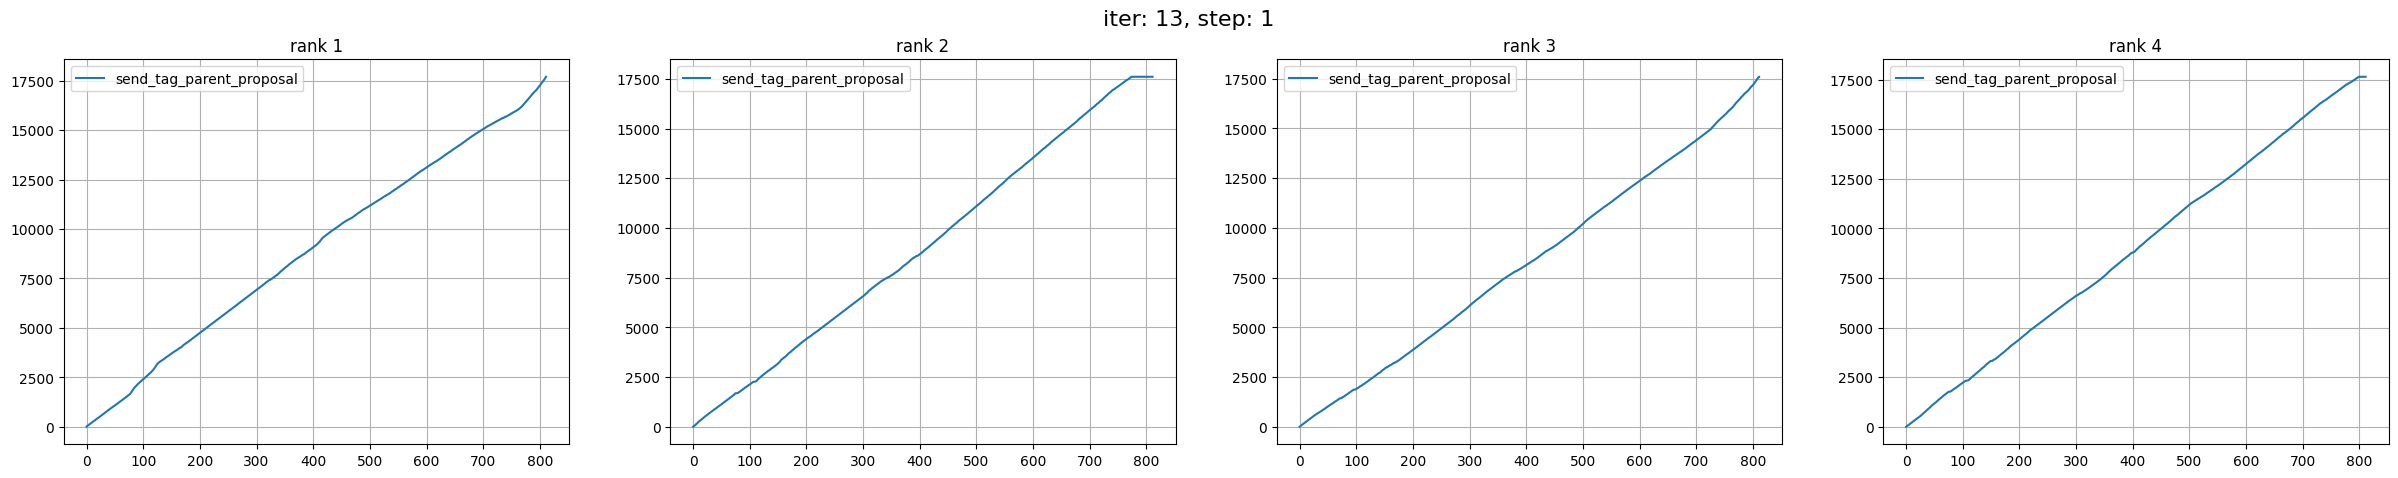

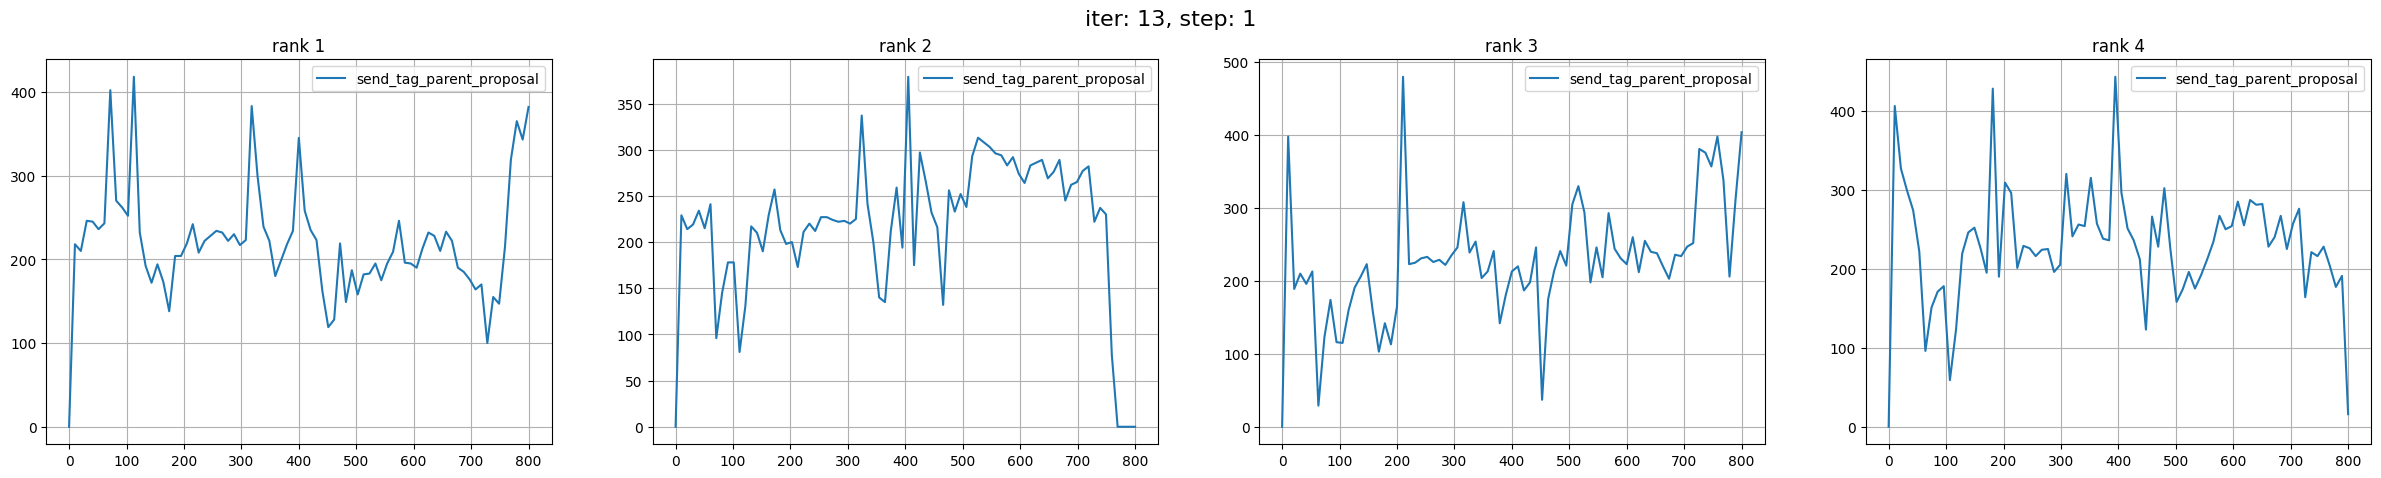

In [124]:
report_log('log2.txt')